##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow 2 quickstart for experts

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/quickstart/advanced"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/advanced.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/quickstart/advanced.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/quickstart/advanced.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This is a [Google Colaboratory](https://colab.research.google.com/notebooks/welcome.ipynb) notebook file. Python programs are run directly in the browser—a great way to learn and use TensorFlow. To follow this tutorial, run the notebook in Google Colab by clicking the button at the top of this page.

1. In Colab, connect to a Python runtime: At the top-right of the menu bar, select *CONNECT*.
2. Run all the notebook code cells: Select *Runtime* > *Run all*.

Download and install TensorFlow 2. Import TensorFlow into your program:

Note: Upgrade `pip` to install the TensorFlow 2 package. See the [install guide](https://www.tensorflow.org/install) for details.

Import TensorFlow into your program:

In [ ]:
import tensorflow as tf
import numpy as np
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

TensorFlow version: 2.6.0


Load and prepare the [MNIST dataset](http://yann.lecun.com/exdb/mnist/).

In [ ]:
#load data from minist
#tf.keras.datasets.mnist라는 클래스에는 load_data()라는 메소드 하나만 존재하고 이 메소드는 
#(x_train, y_train), (x_test, y_test)의 형태로 데이터를 리턴한다.
#각 데이터의 사이즈가 존재할 텐데, tuple of numpy이고 각각 차례대로 (60000, 28, 28), (60000,), (10000, 28, 28), (10000)
#그리고 x 데이터는 0-255사이의 값을 갖고 y는 0-9사이의 값을 갖는다. 
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

# Add a channels dimension
#???
#데이터를 모델에 집어넣기 전에 데이터의 사이즈를 맞춰주는 작업이 필요하다
#???
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

11501568/11490434 [==============================] - 2s 0us/step


In [ ]:
temp = np.array([[1,2], [2,3]])
temp = temp[..., tf.newaxis].astype('float32')
temp.shape


(2, 2, 1)

Use `tf.data` to batch and shuffle the dataset:

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)

#주의점
#train_ds.shuffle(n)이 자체로 train_ds가 변하는 것이 아니다. 즉, 이 함수의 리턴값을 받아서 사용해야 한다
#new_train_ds = train_ds.shuffle(n) 

#만약 현재 TensorDataset 타입의 데이터를 출력해서 보고 싶을 땐 
#list(변수명.as_numpy_iterator())

#batch는 32씩 frist dimension의 기준으로 잘라서 (64, 28, 28, 1)인 데이터를 (2, 32, 28, 28, 1)의 크기로 바꿔준다.
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

Build the `tf.keras` model using the Keras [model subclassing API](https://www.tensorflow.org/guide/keras#model_subclassing):

In [ ]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__() #base class의 상속이 자동으로 일어나는 것을 방지하는 역할을 한다.
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10)

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
model = MyModel()

Choose an optimizer and loss function for training: 

In [ ]:
#opimization에서 어떻게 underfitting된 것을 target function과 비슷하게 만들것인지 고민하는 부분
#1. 어떻게 에러를 정의할 것인가
#2. Adam은 weight를 업데이트할 때 어떤 룰로 업데이트를 할 것인가
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

Select metrics to measure the loss and the accuracy of the model. These metrics accumulate the values over epochs and then print the overall result.

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

Use `tf.GradientTape` to train the model:

In [ ]:
#@tf.function의미
#잘모르겟다 https://www.tensorflow.org/guide/function?hl=ko#%EC%84%A4%EC%A0%95

#tf.GradientTape()의 역할

#with...as...문법

@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

Test the model:

In [ ]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

Epoch 1, Loss: 0.1400374323129654, Accuracy: 95.78166961669922, Test Loss: 0.06221171095967293, Test Accuracy: 97.93999481201172
Epoch 2, Loss: 0.045882754027843475, Accuracy: 98.5816650390625, Test Loss: 0.05920981615781784, Test Accuracy: 98.18000030517578
Epoch 3, Loss: 0.02345551736652851, Accuracy: 99.2699966430664, Test Loss: 0.05412271246314049, Test Accuracy: 98.22999572753906
Epoch 4, Loss: 0.014287136495113373, Accuracy: 99.5633316040039, Test Loss: 0.06601430475711823, Test Accuracy: 98.07999420166016
Epoch 5, Loss: 0.010406095534563065, Accuracy: 99.67500305175781, Test Loss: 0.07218995690345764, Test Accuracy: 98.25999450683594


The image classifier is now trained to ~98% accuracy on this dataset. To learn more, read the [TensorFlow tutorials](https://www.tensorflow.org/tutorials).

In [1]:
!pip install scipy

In [ ]:
import scipy as sc

# TensorFlow 2 quickstart for beginners

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/quickstart/beginner"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/quickstart/beginner.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This short introduction uses [Keras](https://www.tensorflow.org/guide/keras/overview) to:

1. Build a neural network that classifies images.
2. Train this neural network.
3. And, finally, evaluate the accuracy of the model.

This is a [Google Colaboratory](https://colab.research.google.com/notebooks/welcome.ipynb) notebook file. Python programs are run directly in the browser—a great way to learn and use TensorFlow. To follow this tutorial, run the notebook in Google Colab by clicking the button at the top of this page.

1. In Colab, connect to a Python runtime: At the top-right of the menu bar, select *CONNECT*.
2. Run all the notebook code cells: Select *Runtime* > *Run all*.

Download and install TensorFlow 2. Import TensorFlow into your program:

Note: Upgrade `pip` to install the TensorFlow 2 package. See the [install guide](https://www.tensorflow.org/install) for details.

In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.6.0


Load and prepare the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). Convert the samples from integers to floating-point numbers:

In [12]:
mnist = tf.keras.datasets.mnist

#mnist.load_data()는 2 아이템을 갖는 튜플을 리턴하고 각 튜플은 또 2개의 아이템을 갖는 튜플을 갖고 있다.
((x_train, y_train), (x_test, y_test)) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0


In [11]:
또 x_train.shape

(60000, 28, 28)

In [5]:
#tuple does not supprot item assignment

# tu = (1,2,3,4,5)
# li = [1,2,3,4,5]
# tu[4] = 4
# li[4]= 4
# tu

TypeError: ignored

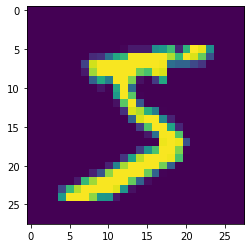

In [4]:
import matplotlib.pyplot as plt
sample_data = x_train[0]
plt.imshow(sample_data)
plt.show()

Build the `tf.keras.Sequential` model by stacking layers. Choose an optimizer and loss function for training:

In [9]:
from tensorflow import keras

model = keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

For each example the model returns a vector of "[logits](https://developers.google.com/machine-learning/glossary#logits)" or "[log-odds](https://developers.google.com/machine-learning/glossary#log-odds)" scores, one for each class.

In [12]:
predictions = model(x_train[:1]).numpy()
predictions


array([[ 0.2707481 ,  0.5541496 , -0.24724308,  0.39897346, -0.3609015 ,
         0.462007  , -0.30886912, -0.79896414, -0.30085406,  0.07693647]],
      dtype=float32)

The `tf.nn.softmax` function converts these logits to "probabilities" for each class: 

In [13]:
#softmax함수 층은 실수 결과를 확률결과로 바꿔주는 역할을 하는데 
tf.nn.softmax(predictions).numpy()

array([[0.12354367, 0.1640213 , 0.07359695, 0.14044558, 0.06568991,
        0.14958334, 0.06919838, 0.04238873, 0.06975524, 0.1017769 ]],
      dtype=float32)

Note: It is possible to bake this `tf.nn.softmax` in as the activation function for the last layer of the network. While this can make the model output more directly interpretable, this approach is discouraged as it's impossible to
provide an exact and numerically stable loss calculation for all models when using a softmax output. 

The `losses.SparseCategoricalCrossentropy` loss takes a vector of logits and a `True` index and returns a scalar loss for each example.

In [16]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

This loss is equal to the negative log probability of the true class:
It is zero if the model is sure of the correct class.

This untrained model gives probabilities close to random (1/10 for each class), so the initial loss should be close to `-tf.math.log(1/10) ~= 2.3`.

In [14]:
y_train[:1]

array([5], dtype=uint8)

In [17]:
loss_fn(y_train[:1], predictions).numpy()

1.8999016

In [20]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy', 'mse'])

The `Model.fit` method adjusts the model parameters to minimize the loss: 

In [21]:
#왜 점점 더 mse가 커지지?
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0683 - accuracy: 0.9780 - mse: 144.2621
Epoch 2/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0603 - accuracy: 0.9808 - mse: 159.4572
Epoch 3/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0521 - accuracy: 0.9829 - mse: 175.6399
Epoch 4/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0484 - accuracy: 0.9845 - mse: 197.4637
Epoch 5/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0460 - accuracy: 0.9845 - mse: 216.4452


The `Model.evaluate` method checks the models performance, usually on a "[Validation-set](https://developers.google.com/machine-learning/glossary#validation-set)" or "[Test-set](https://developers.google.com/machine-learning/glossary#test-set)".

In [28]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 1s - loss: 0.0674 - accuracy: 0.9780 - mse: 208.1577


[0.06743393838405609, 0.9779999852180481, 208.15765380859375]

The image classifier is now trained to ~98% accuracy on this dataset. To learn more, read the [TensorFlow tutorials](https://www.tensorflow.org/tutorials/).

If you want your model to return a probability, you can wrap the trained model, and attach the softmax to it:

In [29]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [30]:
probability_model(x_test[:5])

<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[1.26815621e-07, 4.15350065e-08, 7.94715106e-06, 9.21188854e-04,
        1.99873451e-11, 4.33140855e-07, 2.75600804e-13, 9.99065578e-01,
        1.38839951e-07, 4.52932954e-06],
       [7.18249042e-14, 1.10328720e-05, 9.99988914e-01, 9.50435908e-09,
        1.57565137e-18, 5.61111053e-12, 1.17896968e-11, 1.11768295e-19,
        1.11127596e-08, 1.02549601e-17],
       [3.31742314e-08, 9.99045193e-01, 2.87447965e-05, 2.24377018e-07,
        1.04830660e-05, 9.11223239e-08, 3.30365197e-06, 2.41093621e-05,
        8.87782720e-04, 5.87828559e-08],
       [9.98234391e-01, 3.24098630e-11, 1.65496949e-05, 1.87533047e-08,
        1.83417865e-06, 1.78290757e-05, 1.65934023e-03, 5.31756541e-08,
        5.67275663e-07, 6.94411938e-05],
       [7.52506857e-09, 1.73887648e-14, 4.72211825e-09, 5.56545643e-10,
        9.99146581e-01, 1.16975691e-08, 1.75964004e-07, 8.65841969e-07,
        1.11812675e-08, 8.52348923e-04]], dtype=float32)>

In [31]:
loss_fn_1 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

probability_model.compile(
    optimizer='SGD',
    loss=loss_fn_1,
    metrics=['accuracy', 'mse'])

In [ ]:
probability_model.fit(x_train, y_train, epochs=1500)